<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/DataMinining%20the%20Water%20Table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 14.5 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 81.9 MB/s 
     |████████████████████████████████| 365 kB 87.8 MB/s 
     |████████████████████████████████| 4.7 MB 76.1 MB/s 
     |████████████████████████████████| 212 kB 93.6 MB/s 
     |████████████████████████████████| 141 kB 91.7 MB/s 
     |████████████████████████████████| 101 kB 14.9 MB/s 
     |████████████████████████████████| 596 kB 76.5 MB/s 
     |████████████████████████████████| 127 kB 94.6 MB/s 
     |████████████████████████████████| 6.6 MB 52.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

#Pump it Up: Data Mining the Water Table
HOSTED BY DRIVENDATA

## The Dataset

In [3]:
import pathlib 
path = pathlib.Path('/content/gdrive/MyDrive/Water')

In [4]:

Path.BASE_PATH = path

### Look at the Data

In any sort of data science work, it's important to *look at your data directly* to make sure you understand the format, how it's stored, what types of values it holds, etc. Even if you've read a description of the data, the actual data may not be what you expect. We'll start by reading the training set into a Pandas DataFrame. Generally it's a good idea to specify `low_memory=False` unless Pandas actually runs out of memory and returns an error. The `low_memory` parameter, which is `True` by default, tells Pandas to only look at a few rows of data at a time to figure out what type of data is in each column. This means that Pandas can actually end up using different data type for different rows, which generally leads to data processing errors or model training problems later.

In [5]:
df = pd.read_csv(path/'train.csv', low_memory=False)

In [6]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [7]:
dep_var = 'status_group'

We are now ready to explore our first machine learning algorithm for tabular data: decision trees.

## Decision Trees

A piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

In [8]:
procs = [Categorify, FillMissing]

`TabularPandas` will also handle splitting the dataset into training and validation sets for us. However we need to be very careful about our validation set. We want to design it so that it is like the *test set* Kaggle will use to judge the contest.

We don't get to see the test set. But we do want to define our validation data so that it has the same sort of relationship to the training data as the test set will have.

In some cases, just randomly choosing a subset of your data points will do that.

`TabularPandas` needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function `cont_cat_split`:

In [18]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [21]:
cont

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

In [20]:
del cont[0]

In [22]:
cat

['date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [23]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [24]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var,splits=splits)

A `TabularPandas` behaves a lot like a fastai `Datasets` object, including providing `train` and `valid` attributes:

In [25]:
len(to.train),len(to.valid)

(47520, 11880)

We can see that the data is still displayed as strings for categories (we only show a few columns here because the full table is too big to fit on a page):

In [26]:
#hide_output
to.show(3)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
8137,4/6/2011,Government Of Tanzania,Government,Vitaliusi Mwakato,Lake Rukwa,Trm,Mbeya,Chunya,Makongorosi,True,GeoData Consultants Ltd,VWC,#na#,True,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,0.0,0,33.163460,-8.419100,0,12,1,0,0,functional needs repair
18294,12/3/2013,Private Individual,Dmdd,Kambiya Fisi,Internal,Mende,Arusha,Karatu,Qurus,True,GeoData Consultants Ltd,VWC,Gyewasu,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,5.0,1472,35.635307,-3.393229,0,24,30,120,2002,functional
13628,10/12/2012,Rwssp,RWSSP,Serengeti,Internal,Busubi,Shinyanga,Shinyanga Rural,Didia,True,GeoData Consultants Ltd,WUG,#na#,True,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,other,other,unknown,other,other,0.0,0,33.068390,-3.806693,0,17,3,0,0,non functional


However, the underlying items are all numeric:

In [27]:
#hide_output
to.items.head(3)

,id,amount_tsh,date_recorded,funder,...,source_class,waterpoint_type,waterpoint_type_group,status_group
8137,19700,0.0,248,457,...,1,2,2,1
18294,17515,5.0,112,1273,...,2,2,2,0
13628,62266,0.0,39,1417,...,3,7,6,2


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category, in which case the ordering you chose is used. We can see the mapping by looking at the `classes` attribute:

Since it takes a minute or so to process the data to get to this point, we should save it—that way in the future we can continue our work from here without rerunning the previous steps. fastai provides a `save` method that uses Python's *pickle* system to save nearly any Python object:

In [28]:
save_pickle(path/'to.pkl',to)

To read this back later, you would type:

```python
to = (path/'to.pkl').load()
```

Now that all this preprocessing is done, we are ready to create a decision tree.

### Creating the Decision Tree

To begin, we define our independent and dependent variables:

In [29]:
#hide
to = load_pickle(path/'to.pkl')

In [30]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Random Forests

### Creating a Random Forest

We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).

In the following function definition `n_estimators` defines the number of trees we want, `max_samples` defines how many rows to sample for training each tree, and `max_features` defines how many columns to sample at each split point (where `0.5` means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same `min_samples_leaf` parameter we used in the last section. Finally, we pass `n_jobs=-1` to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
def rf(xs, y, n_estimators=500, max_samples=10000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [37]:
m = rf(xs, y);

In [38]:
yt_pre = m.predict(xs)
yv_pre = m.predict(valid_xs)

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(y, yt_pre)


0.8254208754208754

In [40]:
accuracy_score(valid_y, yv_pre)

0.79503367003367

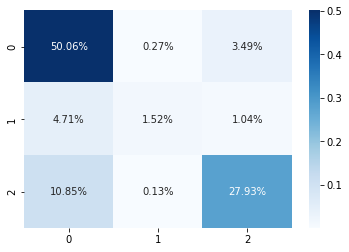

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_y, yv_pre)
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

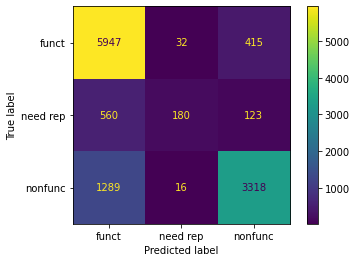

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['funct','need rep','nonfunc'])
disp.plot()
plt.show()

We are clearly not spoting the need for repairs and 40% of the non functional

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

### Tree Variance for Prediction Confidence

We saw how the model averages the individual tree's predictions to get an overall prediction—that is, an estimate of the value. But how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions across the trees, instead of just the mean. This tells us the *relative* confidence of predictions. In general, we would want to be more cautious of using the results for rows where trees give very different results (higher standard deviations), compared to cases where they are more consistent (lower standard deviations).

In the earlier section on creating a random forest, we saw how to get predictions over the validation set, using a Python list comprehension to do this for each tree in the forest:

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
preds.shape

(200, 11880)

Now we have a prediction for every tree and every auction (40 trees and 7,988 auctions) in the validation set.

Using this we can get the standard deviation of the predictions over all the trees, for each auction:

In [ ]:
preds_std = preds.std(0)

Here are the standard deviations for the predictions for the first 10 houses —that is, the ten five rows of the validation set:

In [ ]:
preds_std[:10]

array([0.8357033 , 0.98202597, 0.64992307, 0.75332596, 0.8291562 , 0.82365041, 0.5487258 , 0.72510344, 0.7816489 , 0.93529407])

As you can see, the confidence in the predictions varies widely. For some houses, there is a low standard deviation because the trees agree. For others it's higher, as the trees don't agree. This is information that would be useful in a production setting; for instance, if you were using this model to decide what items to bid on at auction, a low-confidence prediction might cause you to look more carefully at an item before you made a bid.

### Feature Importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with (not surprisingly) `YearMade` and `ProductSize` being at the top of the list:

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
23,quantity,0.120372
24,quantity_group,0.103456
28,waterpoint_type,0.058536
32,longitude,0.051200
29,waterpoint_type_group,0.045278
38,construction_year,0.042974
8,ward,0.036736
30,id,0.036620
33,latitude,0.036525
0,date_recorded,0.034974


A plot of the feature importances shows the relative importances more clearly:

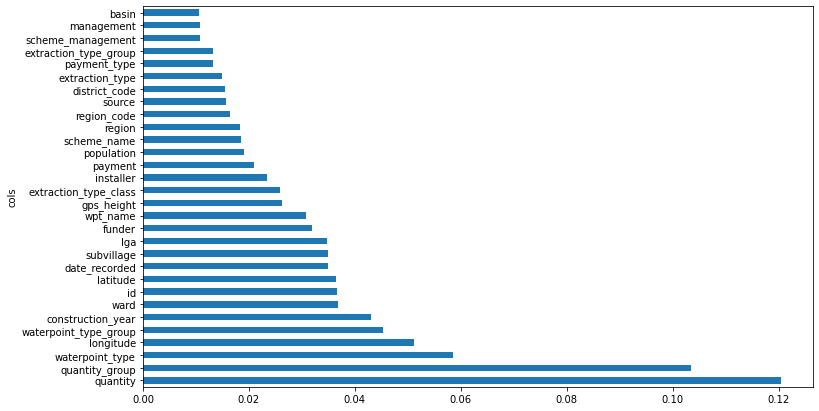

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

### Removing Low-Importance Variables

It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005:

In [ ]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

31

We can retrain our model using just this subset of the columns:

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = rf(xs_imp, y)

And here's the result:

In [ ]:
yt_pre = m.predict(xs_imp)
yv_pre = m.predict(valid_xs_imp)


In [ ]:
accuracy_score(y, yt_pre)

0.7252525252525253

In [ ]:
accuracy_score(valid_y, yv_pre)

0.7239057239057239

Our accuracy is about the same, but we have far fewer columns to study:

In [ ]:
len(xs.columns), len(xs_imp.columns)

(39, 31)

We've found that generally the first step to improving a model is simplifying it—83 columns was too many for us to study them all in depth! Furthermore, in practice often a simpler, more interpretable model is easier to roll out and maintain.

This also makes our feature importance plot easier to interpret. Let's look at it again:

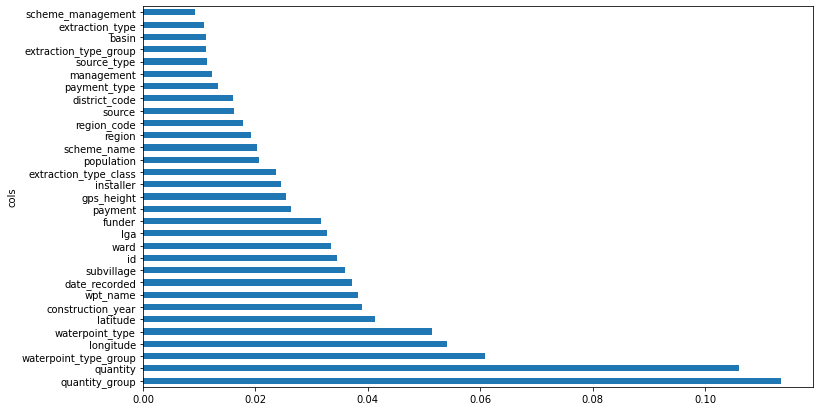

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp));

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings: for example, `GarageArea` and `GarageCars`. Let's try to remove any redundent features. 

### Removing Redundant Features

Let's start with:

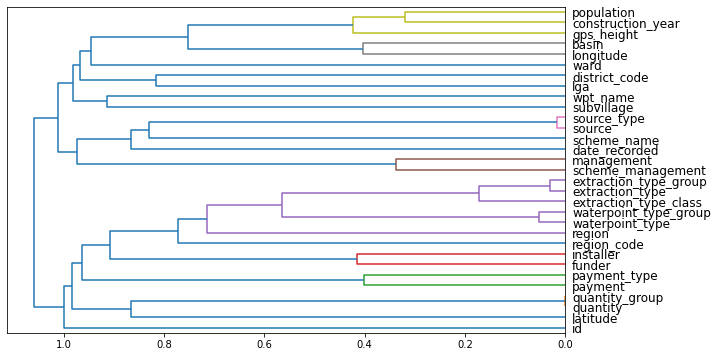

In [ ]:
cluster_columns(xs_imp)

In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left. 

> note: Determining Similarity: The most similar pairs are found by calculating the _rank correlation_, which means that all the values are replaced with their _rank_ (i.e., first, second, third, etc. within the column), and then the _correlation_ is calculated. (Feel free to skip over this minor detail though, since it's not going to come up again in the book!)

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model. (In statistics it's called *R^2*, although the details aren't important for this explanation.) We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns:

In [ ]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=15,
        max_samples=500, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Here's our baseline:

In [ ]:
get_oob(xs_imp)

0.7152988215488215

Now we try removing each of our potentially redundant variables, one at a time:

In [ ]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'source_type', 'extraction_type_group', 'waterpoint_type_group')}

{'extraction_type_group': 0.7147306397306398,
 'source_type': 0.7154250841750842,
 'waterpoint_type_group': 0.7165824915824915}

Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier. Let's see what that does:

In [ ]:
to_drop = ['source_type', 'extraction_type_group', 'waterpoint_type_group']
get_oob(xs_imp.drop(to_drop, axis=1))

0.7134048821548822

Looking good! This is really not much worse than the model with all the fields. Let's create DataFrames without these columns, and save them:

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [ ]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

We can load them back later with:

In [ ]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [ ]:
m = rf(xs_final, y)

## Extrapolation and Neural Networks

A problem with random forests, like all machine learning or deep learning algorithms, is that they don't always generalize well to new data. We will see in which situations neural networks generalize better, but first, let's look at the extrapolation problem that random forests have.

### Using a Neural Network

We can use the same approach to build a neural network model. Let's first replicate the steps we took to set up the `TabularPandas` object:

In [43]:
df_nn = pd.read_csv(path/'train.csv', low_memory=False)

We can leverage the work we did to trim unwanted columns in the random forest by using the same set of columns for our neural network , plus high cardinality ones:

In [44]:
df_nn_final= df_nn[list(xs.columns) + [dep_var]]

In [45]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          59400 non-null  object 
 1   funder                 55765 non-null  object 
 2   installer              55745 non-null  object 
 3   wpt_name               59400 non-null  object 
 4   basin                  59400 non-null  object 
 5   subvillage             59029 non-null  object 
 6   region                 59400 non-null  object 
 7   lga                    59400 non-null  object 
 8   ward                   59400 non-null  object 
 9   public_meeting         56066 non-null  object 
 10  recorded_by            59400 non-null  object 
 11  scheme_management      55523 non-null  object 
 12  scheme_name            31234 non-null  object 
 13  permit                 56344 non-null  object 
 14  extraction_type        59400 non-null  object 
 15  ex

In [46]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=5, dep_var=dep_var)

In [47]:
cont_nn

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:

In [48]:
df_nn_final[cat_nn].nunique()

date_recorded              356
funder                    1897
installer                 2145
wpt_name                 37400
basin                        9
                         ...  
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
Length: 30, dtype: int64

We can create our `TabularPandas` object in the same way as when we created our random forest, with one very important addition: normalization. A random forest does not need any normalization—the tree building procedure cares only about the order of values in a variable, not at all about how they are scaled. But as we have seen, a neural network definitely does care about this. Therefore, we add the `Normalize` processor when we build our `TabularPandas` object:

In [49]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes:

In [114]:
dls = to_nn.dataloaders(128)

We can now create the `Learner` to create this tabular model. As usual, we use the application-specific learner function, to take advantage of its application-customized defaults. We set the loss function to MSE, since that's what this competition uses.

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but here we've got quite a large dataset, so we increase the layer sizes to 500 and 250:

In [61]:
learn4 = tabular_learner(dls, layers=[500,250], metrics=accuracy)

SuggestedLRs(valley=0.0030199517495930195)

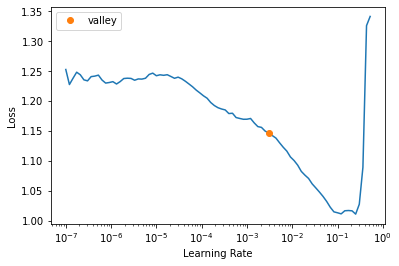

In [62]:
learn4.lr_find()

There's no need to use `fine_tune`, so we'll train with `fit_one_cycle` for a few epochs and see how it looks:

In [63]:
learn4.fit_one_cycle(1, 0.005,wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.540917,0.516799,0.787879,00:08


In [90]:
learn4.save(path/'nn')

Path('nn.pth')

In [106]:
df_test = pd.read_csv('/content/gdrive/MyDrive/Water/test.csv')

In [115]:
test_dl = dls.test_dl(df_test, with_labels=False)

In [153]:
preds = learn.get_preds(dl=test_dl)

In [154]:
import pandas as pd
#preds[0]

pada = pd.DataFrame(preds[0]).astype("float")

In [155]:
pada

,0,1,2
0,9.936985e-01,2.712825e-03,3.588649e-03
1,4.506502e-01,6.978828e-03,5.423710e-01
2,9.704171e-01,1.144104e-02,1.814186e-02
3,2.077830e-07,3.245149e-09,9.999998e-01
4,1.000000e+00,1.126012e-09,2.800179e-09
...,...,...,...
14845,9.939341e-01,1.179618e-03,4.886195e-03
14846,1.000000e+00,4.119332e-08,4.216488e-08
14847,6.252663e-01,3.726478e-01,2.085948e-03
14848,9.846011e-01,3.015533e-07,1.539861e-02


In [158]:
maxValuesObj = pd.DataFrame({'max': pada.max(axis=1)})


In [160]:
pada.columns.values

array([0, 1, 2])

In [162]:
pada['pred'] = pada.idxmax(axis=1)

In [163]:
pada

,0,1,2,pred
0,9.936985e-01,2.712825e-03,3.588649e-03,0
1,4.506502e-01,6.978828e-03,5.423710e-01,2
2,9.704171e-01,1.144104e-02,1.814186e-02,0
3,2.077830e-07,3.245149e-09,9.999998e-01,2
4,1.000000e+00,1.126012e-09,2.800179e-09,0
...,...,...,...,...
14845,9.939341e-01,1.179618e-03,4.886195e-03,0
14846,1.000000e+00,4.119332e-08,4.216488e-08,0
14847,6.252663e-01,3.726478e-01,2.085948e-03,0
14848,9.846011e-01,3.015533e-07,1.539861e-02,0


### Sidebar: fastai's Tabular Classes

In fastai, a tabular model is simply a model that takes columns of continuous or categorical data, and predicts a category (a classification model) or a continuous value (a regression model). Categorical independent variables are passed through an embedding, and concatenated, as we saw in the neural net we used for collaborative filtering, and then continuous variables are concatenated as well.

The model created in `tabular_learner` is an object of class `TabularModel`. Take a look at the source for `tabular_learner` now (remember, that's `tabular_learner??` in Jupyter). You'll see that like `collab_learner`, it first calls `get_emb_sz` to calculate appropriate embedding sizes (you can override these by using the `emb_szs` parameter, which is a dictionary containing any column names you want to set sizes for manually), and it sets a few other defaults. Other than that, it just creates the `TabularModel`, and passes that to `TabularLearner` (note that `TabularLearner` is identical to `Learner`, except for a customized `predict` method).

That means that really all the work is happening in `TabularModel`, so take a look at the source for that now. With the exception of the `BatchNorm1d` and `Dropout` layers (which we'll be learning about shortly), you now have the knowledge required to understand this whole class. Take a look at the discussion of `EmbeddingNN` at the end of the last chapter. Recall that it passed `n_cont=0` to `TabularModel`. We now can see why that was: because there are zero continuous variables (in fastai the `n_` prefix means "number of," and `cont` is an abbreviation for "continuous").

Another thing that can help with generalization is to use several models and average their predictions—a technique, as mentioned earlier, known as *ensembling*.

## Ensembling

Think back to the original reasoning behind why random forests work so well: each tree has errors, but those errors are not correlated with each other, so the average of those errors should tend towards zero once there are enough trees. Similar reasoning could be used to consider averaging the predictions of models trained using different algorithms.

In our case, we have two very different models, trained using very different algorithms: a random forest, and a neural network. It would be reasonable to expect that the kinds of errors that each one makes would be quite different. Therefore, we might expect that the average of their predictions would be better than either one's individual predictions.

As we saw earlier, a random forest is itself an ensemble. But we can then include a random forest in *another* ensemble—an ensemble of the random forest and the neural network! While ensembling won't make the difference between a successful and an unsuccessful modeling process, it can certainly add a nice little boost to any models that you have built.

One minor issue we have to be aware of is that our PyTorch model and our sklearn model create data of different types: PyTorch gives us a rank-2 tensor (i.e, a column matrix), whereas NumPy gives us a rank-1 array (a vector). `squeeze` removes any unit axes from a tensor, and `to_np` converts it into a NumPy array:

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

This gives us a better result than any model separately

In [ ]:
r_mse(ens_preds,valid_y)

24267.102717

One more technique that has gotten great results is to use embeddings learned by a neural net in a machine learning model.

## Using pretrained embeddings to improve random forest performance


In [ ]:
def embed_features(learner, xs):
    xs = xs.copy()
    for i, feature in enumerate(learner.dls.cat_names):
        emb = learner.model.embeds[i]
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int64)), index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        xs.drop(columns=feature, inplace=True)
        xs = xs.join(new_feat)
    return xs


In [ ]:
cat_features = learn.dls.cat_names

def add_embeds(learn, x):
    x = x.copy()
    for i, cat in enumerate(cat_features):
        emb = learn.embeds[i]
        vec = tensor(x[cat], dtype=torch.int64) # this is on cpu
        emb_data = emb(vec)
        emb_names = [f'{cat}_{j}' for j in range(emb_data.shape[1])]
        
        emb_df = pd.DataFrame(emb_data, index=x.index, columns=emb_names)
        x = x.drop(columns=cat)
        x = x.join(emb_df)
    return x

add_embeds(learn,to_nn.train.xs)

,OverallQual,GrLivArea,BsmtFinSF1,YearBuilt,LotArea,2ndFlrSF,YearRemodAdd,MasVnrArea,TotRmsAbvGrd,GarageCars_0,GarageCars_1,GarageCars_2,GarageCars_3,ExterQual_0,ExterQual_1,ExterQual_2,ExterQual_3,KitchenQual_0,KitchenQual_1,KitchenQual_2,KitchenQual_3,FullBath_0,FullBath_1,FullBath_2,FullBath_3,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,MSSubClass_0,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSSubClass_5,MSSubClass_6,MSSubClass_7,MasVnrArea_na_0,MasVnrArea_na_1,MasVnrArea_na_2
1395,1.346346,1.812191,-0.950258,1.112023,0.218292,2.290928,1.015574,0.768834,1.527284,-0.371898,0.271798,-0.353977,-0.541258,0.231444,0.902354,-0.360187,-0.090635,-0.430029,-0.376398,0.371185,0.554425,0.728381,0.688040,-1.276538,0.493806,0.365453,0.164882,-0.046585,-0.409193,-0.363506,0.121034,0.495342,0.057562,0.234534,0.248210,-0.636019,0.182199,0.044924,-0.037528,0.424486,0.568255,-0.207187,-0.004554,-0.177462,-0.286638,0.484345,0.114428,0.231949,-0.196089,-0.319453,-0.327187,-0.212140,-0.368804,-0.171623,0.280848,0.154338,-0.017116,0.050601,0.103187,-0.191799,-0.378358,0.148624,-0.163257,-0.913688,0.988551,-1.029437
1081,-0.784456,-0.895536,0.816125,-0.267663,-0.302151,-0.789709,-1.063511,-0.571821,-0.913863,-0.422371,1.031657,-0.975907,-0.840798,0.354238,1.368256,0.083012,0.000093,-0.212046,0.517044,0.706319,1.039495,0.611106,0.471023,-0.716133,-0.035498,0.871657,0.246796,-0.714702,-0.791369,-0.226056,-0.168886,0.700656,0.228744,-0.176922,-0.544135,-0.151451,-0.028602,-0.662329,0.328475,-0.547750,0.115853,-0.245288,0.115489,0.033480,-0.020475,-0.124803,-0.134231,0.095484,-0.360175,-0.067762,-0.219155,-0.148862,-0.096648,-0.008878,-0.029317,1.236115,0.412332,-0.647051,0.693658,-0.511767,-0.611768,0.585687,-0.394186,-0.913688,0.988551,-1.029437
80,-0.074189,1.173753,0.010105,-0.103415,0.252048,1.402590,-0.821757,2.580085,0.916998,-0.422371,1.031657,-0.975907,-0.840798,0.354238,1.368256,0.083012,0.000093,-0.430029,-0.376398,0.371185,0.554425,0.728381,0.688040,-1.276538,0.493806,0.365453,0.164882,-0.046585,-0.409193,-0.285229,0.156441,0.619387,0.292687,-0.513979,-0.480759,-0.049224,-0.227547,-0.427596,0.323901,0.424486,0.568255,-0.207187,-0.004554,-0.177462,-0.286638,0.484345,0.114428,0.231949,-0.196089,-0.319453,-0.327187,-0.212140,-0.368804,-0.171623,0.280848,0.154338,-0.017116,0.050601,0.103187,-0.191799,-0.378358,0.148624,-0.163257,-0.913688,0.988551,-1.029437
646,-0.784456,-0.880514,-0.950258,-0.694708,-0.332380,-0.789709,-1.692071,-0.571821,0.306711,-0.098260,0.662984,-0.457121,-0.337522,0.354238,1.368256,0.083012,0.000093,-0.212046,0.517044,0.706319,1.039495,0.611106,0.471023,-0.716133,-0.035498,0.601194,0.165976,0.176257,-0.291360,-0.285229,0.156441,0.619387,0.292687,-0.513979,-0.480759,-0.049224,-0.227547,-0.427596,0.323901,1.155223,0.026870,-0.174226,-0.235207,-0.141368,-0.275499,-0.074209,0.236989,0.045417,-0.042020,0.397578,0.121484,0.165289,0.145955,0.025789,-0.134742,1.236115,0.412332,-0.647051,0.693658,-0.511767,-0.611768,0.585687,-0.394186,-0.913688,0.988551,-1.029437
587,-0.784456,-1.233533,0.490287,0.356481,-0.177204,-0.789709,-0.144845,-0.571821,-1.524149,-0.098260,0.662984,-0.457121,-0.337522,0.354238,1.368256,0.083012,0.000093,-0.212046,0.517044,0.706319,1.039495,0.611106,0.471023,-0.716133,-0.035498,0.871657,0.246796,-0.714702,-0.791369,-0.226056,-0.168886,0.700656,0.228744,-0.176922,-0.544135,-0.151451,-0.028602,-0.662329,0.328475,-0.547750,0.115853,-0.245288,0.115489,0.033480,-0.020475,-0.124803,-0.134231,0.095484,-0.360175,-0.067762,-0.219155,-0.148862,-0.096648,-0.008878,-0.029317,0.739162,-0.060087,-0.172588,-0.081863,-0.439875,-0.703946,0.170221,

In [ ]:
emb_xs = embed_features(learn, to_nn.train.xs)
emb_valid_xs = embed_features(learn, to_nn.valid.xs)

In [ ]:
m = rf(emb_xs , y)
m_rmse(m, emb_valid_xs, valid_y)

26969.680643

In [ ]:
m = rf(to_nn.train.xs , y)
m_rmse(m,  to_nn.valid.xs, valid_y)

27336.34968

INTENRESTINGLY, THE MODEL WITH EMBEDDINGS IS BETTER THAN THE ORIGINAL RANDOM FOREST, BUT WORST THAN THE EMSEMMBLE, WHEN INTERPRETABILITY IS KEY, NOTE THAT USING THE RF WITH EMBEDDINGS IS THE BEST MODEL WITH ALL THE RANDOM FOREST FUNCTIONALITIES. THIS IS IN LINE WITH THE PAPER FOUNDINGS, WHERE THE USING CATEGORICAL EMBEDDINGS LEADS TO BETTER PERFORMANCE FOR MACHINE LEARNING. IN OUR CASE, AND EMSEMBLE OF MODELS GIVES THE BEST MSE, IN OUR CASE 24K, BETTER THAN THE ORIGINAL RF (28K) AND THE NEURAL NETWORK ALONE (26K)

### Combining Embeddings with Other Methods

The abstract of the entity embedding paper we mentioned at the start of this chapter states: "the embeddings obtained from the trained neural network boost the performance of all tested machine learning methods considerably when used as the input features instead". It includes the very interesting table in <<embedding_mixed>>.

<img alt="Embeddings combined with other methods" width="500" id="embedding_mixed" caption="Effects of using neural network embeddings as input to other machine learning methods (courtesy of Cheng Guo and Felix Berkhahn)" src="https://github.com/fastai/fastbook/blob/master/images/att_00054.png?raw=1">

This is showing the mean average percent error (MAPE) compared among four different modeling techniques, three of which we have already seen, along with *k*-nearest neighbors (KNN), which is a very simple baseline method. The first numeric column contains the results of using the methods on the data provided in the competition; the second column shows what happens if you first train a neural network with categorical embeddings, and then use those categorical embeddings instead of the raw categorical columns in the model. As you see, in every case, the models are dramatically improved by using the embeddings instead of the raw categories.

This is a really important result, because it shows that you can get much of the performance improvement of a neural network without actually having to use a neural network at inference time. You could just use an embedding, which is literally just an array lookup, along with a small decision tree ensemble.

These embeddings need not even be necessarily learned separately for each model or task in an organization. Instead, once a set of embeddings are learned for some column for some task, they could be stored in a central place, and reused across multiple models. In fact, we know from private communication with other practitioners at large companies that this is already happening in many places.

## Conclusion: Our Advice for Tabular Modeling

We have dicussed two approaches to tabular modeling: decision tree ensembles and neural networks. We've also mentioned two different decision tree ensembles: random forests, and gradient boosting machines. Each is very effective, but each also has compromises:

- *Random forests* are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees. But they can be a little less accurate, especially if extrapolation is required, such as predicting future time periods.

- *Gradient boosting machines* in theory are just as fast to train as random forests, but in practice you will have to try lots of different hyperparameters. They can overfit, but they are often a little more accurate than random forests.

- *Neural networks* take the longest time to train, and require extra preprocessing, such as normalization; this normalization needs to be used at inference time as well. They can provide great results and extrapolate well, but only if you are careful with your hyperparameters and take care to avoid overfitting.

We suggest starting your analysis with a random forest. This will give you a strong baseline, and you can be confident that it's a reasonable starting point. You can then use that model for feature selection and partial dependence analysis, to get a better understanding of your data.

From that foundation, you can try neural nets and GBMs, and if they give you significantly better results on your validation set in a reasonable amount of time, you can use them. If decision tree ensembles are working well for you, try adding the embeddings for the categorical variables to the data, and see if that helps your decision trees learn better.